In [1]:
from core.ckan_api_reader import ListResources
from config import CKAN_DOMAIN
from typing import Generator



In [2]:
ckan = ListResources(CKAN_DOMAIN)

In [3]:
CKAN_DOMAIN

'https://repositorio.seade.gov.br/api/3/'

In [4]:
#PROCEDURAl

ckan = ListResources(CKAN_DOMAIN)
nome_pacote = 'domicilios-estado-de-sao-paulo'
nome_recurso = 'Domicílios por distrito do município de São Paulo - 2011 a 2022'
resource_gen = ckan(nome_pacote, search_string=nome_recurso, attr='name',
                             extract=True, parser_params={'sep' : ';'})

df = next(resource_gen)

In [5]:
[pkg for pkg in ckan.pkgs if 'domicilios' in pkg]

['domicilios-estado-de-sao-paulo']

In [6]:
class Extract:
    """Extrai o banco de dados de domícilios por distrito
    no município de São Paulo.
    
    Atualmente, estes dados estão disponíveis diretamente em um único csv."""
    
    def __init__(self):

        self.ckan = ListResources(CKAN_DOMAIN)
        self.nome_pacote = 'domicilios-estado-de-sao-paulo'
        #nome do único recurso que contém os dados
        self.nome_recurso = 'Domicílios por distrito do município de São Paulo - 2011 a 2022'
        
    def get_resource_mdata(self)->dict:

        resource_mdata = self.ckan(self.nome_pacote, as_list=True,
                                   search_string=self.nome_recurso, attr='name')

        return resource_mdata[0]
    
    def csv_gen(self)->Generator:
        
        resource_gen = self.ckan(self.nome_pacote, search_string=nome_recurso, attr='name',
                             extract=True, parser_params={'sep' : ';'})
        
        return resource_gen

In [7]:
extrator = Extract()

In [8]:
gen = extrator.csv_gen()

In [9]:
df = next(gen)

In [10]:
def padronizar_mooca(nom_dist):
    
    if nom_dist.lower()=='mooca':
        return 'Moóca'
    return nom_dist

In [11]:
df['nome_distrito'] = df['nome_distrito'].apply(padronizar_mooca)

In [12]:
df = df.pivot(columns='ano', values='domicilios', index='nome_distrito')

In [13]:
df.dtypes

ano
2011    int64
2012    int64
2013    int64
2014    int64
2015    int64
2016    int64
2017    int64
2018    int64
2019    int64
2020    int64
2021    int64
2022    int64
dtype: object

In [14]:
df.index

Index(['Alto de Pinheiros', 'Anhanguera', 'Aricanduva', 'Artur Alvim',
       'Barra Funda', 'Bela Vista', 'Belém', 'Bom Retiro', 'Brasilândia',
       'Brás', 'Butantã', 'Cachoeirinha', 'Cambuci', 'Campo Belo',
       'Campo Grande', 'Campo Limpo', 'Cangaíba', 'Capão Redondo', 'Carrão',
       'Casa Verde', 'Cidade Ademar', 'Cidade Dutra', 'Cidade Líder',
       'Cidade Tiradentes', 'Consolação', 'Cursino', 'Ermelino Matarazzo',
       'Freguesia do Ó', 'Grajaú', 'Guaianases', 'Iguatemi', 'Ipiranga',
       'Itaim Bibi', 'Itaim Paulista', 'Itaquera', 'Jabaquara', 'Jaguara',
       'Jaguaré', 'Jaraguá', 'Jardim Helena', 'Jardim Paulista',
       'Jardim São Luís', 'Jardim Ângela', 'Jaçanã', 'José Bonifácio',
       'Lajeado', 'Lapa', 'Liberdade', 'Limão', 'Mandaqui', 'Marsilac',
       'Moema', 'Morumbi', 'Moóca', 'Parelheiros', 'Pari', 'Parque do Carmo',
       'Pedreira', 'Penha', 'Perdizes', 'Perus', 'Pinheiros', 'Pirituba',
       'Ponte Rasa', 'Raposo Tavares', 'República', 'Rio P

In [15]:
import requests

In [68]:
def get_distritos():
    
    host = 'https://api.observasampa.prefeitura.sp.gov.br/'
    endpoint = 'v1/front_end/regioes/'
    query_param = '?cd_nivel_regiao=1'
    
    url = host + endpoint + query_param
    
    with requests.get(url) as r:
        return r.json()
    
def build_code_distrito(cd_regiao:int)->str:
    
    cd_regiao = str(cd_regiao)
    code ='D' + cd_regiao[1:]
    
    return code


def dist_nm_to_code(distritos:list)->dict:
    
    mapper = {}
    
    for dist in distritos:
        nm = dist['nm_regiao']
        code = build_code_distrito(dist['cd_regiao'])
        
        mapper[nm] = code
        
        
    return mapper

In [18]:
dists_observa = get_distritos()

In [19]:
nom_dists_observa = set([dist['nm_regiao'] for dist in
                     dists_observa])

In [20]:
for dist in df.index:
    if dist not in nom_dists_observa:
        raise ValueError(f'Nome do distrito fora do padrão: {dist}')

In [21]:
mapper_distritos = dist_nm_to_code(dists_observa)

In [22]:
df  = df.reset_index()

In [23]:
df['Região'] = df['nome_distrito'].apply(lambda x: mapper_distritos[x])

In [24]:
df

ano,nome_distrito,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,Região
0,Alto de Pinheiros,15439,15469,15499,15527,15555,15564,15572,15579,15586,15592,15573,15553,D02
1,Anhanguera,20320,21242,22204,23208,24255,25093,25959,26853,27777,28732,29520,30330,D03
2,Aricanduva,27732,27802,27870,27936,28001,28098,28194,28289,28383,28476,28613,28750,D04
3,Artur Alvim,33827,33940,34052,34161,34268,34389,34509,34627,34744,34860,34943,35024,D05
4,Barra Funda,5705,5789,5874,5959,6046,6133,6221,6311,6401,6493,6598,6704,D06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Vila Matilde,33765,34040,34314,34589,34863,35108,35353,35598,35843,36088,36281,36474,D91
92,Vila Medeiros,39916,39925,39931,39935,39934,40020,40105,40188,40270,40349,40465,40580,D92
93,Vila Prudente,34983,35260,35536,35812,36088,36323,36557,36792,37026,37260,37428,37594,D93
94,Vila Sônia,35385,36125,36879,37646,38426,39064,39712,40368,41033,41708,42246,42790,D94


In [25]:
mapper_distritos

{'Santo Amaro': 'D71',
 'São Lucas': 'D72',
 'São Mateus': 'D73',
 'São Miguel': 'D74',
 'São Rafael': 'D75',
 'Sapopemba': 'D76',
 'Saúde': 'D77',
 'Sé': 'D78',
 'Socorro': 'D79',
 'Tatuapé': 'D80',
 'Tremembé': 'D81',
 'Tucuruvi': 'D82',
 'Vila Andrade': 'D83',
 'Vila Curuçá': 'D84',
 'Vila Formosa': 'D85',
 'Vila Guilherme': 'D86',
 'Vila Jacuí': 'D87',
 'Vila Leopoldina': 'D88',
 'Vila Maria': 'D89',
 'Vila Mariana': 'D90',
 'Vila Matilde': 'D91',
 'Vila Medeiros': 'D92',
 'Vila Prudente': 'D93',
 'Vila Sônia': 'D94',
 'São Domingos': 'D95',
 'Lajeado': 'D96',
 'Água Rasa': 'D01',
 'Alto de Pinheiros': 'D02',
 'Anhanguera': 'D03',
 'Aricanduva': 'D04',
 'Artur Alvim': 'D05',
 'Barra Funda': 'D06',
 'Bela Vista': 'D07',
 'Belém': 'D08',
 'Bom Retiro': 'D09',
 'Brás': 'D10',
 'Brasilândia': 'D11',
 'Butantã': 'D12',
 'Cachoeirinha': 'D13',
 'Cambuci': 'D14',
 'Campo Belo': 'D15',
 'Campo Grande': 'D16',
 'Campo Limpo': 'D17',
 'Cangaíba': 'D18',
 'Capão Redondo': 'D19',
 'Carrão': 'D

In [26]:
import geopandas as gpd
from zipfile import ZipFile
from io import BytesIO
import os

In [27]:
def get_shape_dists_geosampa():
    
    host = 'https://geosampa.prefeitura.sp.gov.br/'
    endpoint = 'PaginasPublicas/downloadArquivo.aspx?'
    query_params = 'orig=DownloadCamadas&arq=01_Limites Administrativos\\Distrito\\Shapefile\\SIRGAS_SHP_distrito&arqTipo=Shapefile'

    url = host+endpoint+query_params
    
    with requests.get(url) as r:
        return r.content

In [28]:
content_shape = get_shape_dists_geosampa()

In [29]:
io = BytesIO(content_shape)

In [30]:
zip_shp = ZipFile(io)

In [31]:
if not os.path.exists('tmp'):
    os.mkdir('tmp')

In [32]:
zip_shp.extractall('tmp')

In [33]:
geodf = gpd.read_file('tmp/SIRGAS_SHP_distrito/')

<AxesSubplot: >

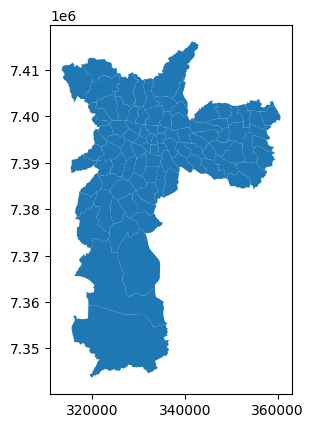

In [34]:
geodf.plot()

In [36]:
dist_to_sub = dict(zip(geodf['ds_nome'], geodf['ds_subpref']))

In [46]:
def remover_acentos(name):
    
    acento_letra = {
        'ç' : 'c',
        'á' : 'a',
        'â' : 'a',
        'à' : 'a',
        'ã' : 'a',
        'ä' : 'a',
        'é' : 'e',
        'ê' : 'e',
        'è' : 'e',
        'ë' : 'e',
        'í' : 'i',
        'î' : 'i',
        'ì' : 'i',
        'ï' : 'i',
        'ó' : 'o',
        'ô' : 'o',
        'ò' : 'o',
        'ø' : 'o',
        'õ' : 'o',
        'ö' : 'o',
        'ú' : 'u',
        'û' : 'u',
        'ù' : 'u',
        'ü' : 'u',
        'ñ' : 'n',
        'ý' : 'y'
    }
    
    chars = list(name)
    
    return ''.join([acento_letra.get(char, char) for char in chars])


In [54]:
df['nome_distrito_geosampa'] = df['nome_distrito'].str.lower().apply(lambda x: remover_acentos(x)).str.upper()

In [55]:
df.head()

ano,nome_distrito,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,Região,nome_distrito_geosampa
0,Alto de Pinheiros,15439,15469,15499,15527,15555,15564,15572,15579,15586,15592,15573,15553,D02,ALTO DE PINHEIROS
1,Anhanguera,20320,21242,22204,23208,24255,25093,25959,26853,27777,28732,29520,30330,D03,ANHANGUERA
2,Aricanduva,27732,27802,27870,27936,28001,28098,28194,28289,28383,28476,28613,28750,D04,ARICANDUVA
3,Artur Alvim,33827,33940,34052,34161,34268,34389,34509,34627,34744,34860,34943,35024,D05,ARTUR ALVIM
4,Barra Funda,5705,5789,5874,5959,6046,6133,6221,6311,6401,6493,6598,6704,D06,BARRA FUNDA


In [58]:
for dist in df['nome_distrito_geosampa'].str.upper():
    if dist not in dist_to_sub:
        raise ValueError(f'Distrito fora do padrão do geosampa: {dist}')

In [60]:
df['nom_subprefeitura'] = df['nome_distrito_geosampa'].apply(lambda x: dist_to_sub[x])

In [64]:
df_subs = df.groupby('nom_subprefeitura').sum(numeric_only =True)

In [66]:
df_subs = df_subs.reset_index()

In [69]:
df_subs.head()

ano,nom_subprefeitura,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,ARICANDUVA-FORMOSA-CARRAO,85712,86236,86756,87275,87793,88268,88741,89213,89684,90154,90572,90990
1,BUTANTA,137930,140065,142230,144423,146641,148480,150337,152214,154110,156024,157575,159138
2,CAMPO LIMPO,190722,195859,201139,206567,212146,216856,221667,226583,231607,236738,241106,245550
3,CAPELA DO SOCORRO,176138,179129,182161,185243,188369,191406,194488,197614,200789,204010,206844,209720
4,CASA VERDE-CACHOEIRINHA,95301,96024,96745,97469,98190,98972,99755,100540,101329,102121,102882,103648


In [89]:
def get_subs():
    
    host = 'https://api.observasampa.prefeitura.sp.gov.br/'
    endpoint = 'v1/front_end/regioes/'
    query_param = '?cd_nivel_regiao=2'
    
    url = host + endpoint + query_param
    
    with requests.get(url) as r:
        return r.json()
    
def build_code_subs(cd_regiao:int)->str:
    
    cd_regiao = str(cd_regiao)
    if int(cd_regiao) <10:
        cd_regiao = '0' + cd_regiao
    code ='S' + cd_regiao
    
    return code


def subs_nm_to_code(subs:list)->dict:
    
    mapper = {}
    
    for sub in subs:
        nm = sub['nm_regiao_padrao']
        code = build_code_subs(sub['cd_regiao'])
        
        mapper[nm] = code
        
        
    return mapper

In [90]:
subs_observa = get_subs()

In [91]:
nms_padrao_subs_observa = set([sub['nm_regiao_padrao'] for sub in subs_observa])

In [92]:
for sub in df_subs['nom_subprefeitura']:
    if sub not in nms_padrao_subs_observa:
        raise ValueError(f'Subprefeitura fora do padrão: {sub}')

In [93]:
mapper = subs_nm_to_code(subs_observa)

In [97]:
df_subs['regiao'] = df_subs['nom_subprefeitura'].apply(lambda x: mapper[x])

In [98]:
df_subs

ano,nom_subprefeitura,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,regiao
0,ARICANDUVA-FORMOSA-CARRAO,85712,86236,86756,87275,87793,88268,88741,89213,89684,90154,90572,90990,S26
1,BUTANTA,137930,140065,142230,144423,146641,148480,150337,152214,154110,156024,157575,159138,S10
2,CAMPO LIMPO,190722,195859,201139,206567,212146,216856,221667,226583,231607,236738,241106,245550,S17
3,CAPELA DO SOCORRO,176138,179129,182161,185243,188369,191406,194488,197614,200789,204010,206844,209720,S19
4,CASA VERDE-CACHOEIRINHA,95301,96024,96745,97469,98190,98972,99755,100540,101329,102121,102882,103648,S04
5,CIDADE ADEMAR,125463,128058,130700,133389,136127,138537,140984,143472,145998,148564,150817,153098,S16
6,CIDADE TIRADENTES,62279,63853,65463,67109,68792,70395,72032,73703,75410,77153,78714,80304,S31
7,ERMELINO MATARAZZO,63318,63945,64576,65211,65852,66443,67037,67634,68235,68840,69409,69980,S22
8,FREGUESIA-BRASILANDIA,123604,125100,126610,128134,129671,131145,132632,134135,135650,137179,138674,140182,S03
9,GUAIANASES,78544,79907,81287,82685,84102,85534,86987,88461,89956,91469,92886,94321,S28


In [101]:
import pandas as pd

In [105]:
df_mun = pd.DataFrame(data = [df_subs.sum()])

In [107]:
df_mun.drop(['nom_subprefeitura', 'regiao'], axis=1, inplace=True)

In [109]:
df_mun['regiao'] = 'M00'

In [110]:
df_mun

ano,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,regiao
0,3627864,3682245,3737441,3793464,3850326,3900375,3951074,4002432,4054458,4107161,4151877,4197080,M00


In [112]:
df_subs.drop('nom_subprefeitura', axis=1, inplace=True)

In [117]:
df_subs.head(1)

ano,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,regiao
0,85712,86236,86756,87275,87793,88268,88741,89213,89684,90154,90572,90990,S26


In [114]:
df.drop(['nome_distrito', 'nome_distrito_geosampa', 'nom_subprefeitura'], axis=1, inplace=True)

In [118]:
df.rename({'Região':'regiao'}, axis=1, inplace=True)

In [119]:
df.head(1)

ano,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,regiao
0,15439,15469,15499,15527,15555,15564,15572,15579,15586,15592,15573,15553,D02


In [120]:
df_final = pd.concat([df, df_subs, df_mun])

In [122]:
df_final['variavel'] = 'V0281'

In [129]:
df_final.to_csv('V0281.csv', sep=';', encoding='latin-1', index=False)

In [130]:
len(df_final)

129

In [131]:
def funcao_generica(*args, **kwargs):
    
    print('Argumentos posicionais', args)
    print('Argumentos de palavra-chave', kwargs)

In [132]:
funcao_generica(1)

Argumentos posicionais (1,)
Argumentos de palavra-chave {}


In [142]:
funcao_generica(1, 289, '1', palavra='chave')

Argumentos posicionais (1, 289, '1')
Argumentos de palavra-chave {'palavra': 'chave'}


In [135]:
a

1

In [136]:
b

2

In [137]:
c

3

In [143]:
df_final

ano,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,regiao,variavel
,,,,,,,,,,,,,,
0,15439,15469,15499,15527,15555,15564,15572,15579,15586,15592,15573,15553,D02,V0281
1,20320,21242,22204,23208,24255,25093,25959,26853,27777,28732,29520,30330,D03,V0281
2,27732,27802,27870,27936,28001,28098,28194,28289,28383,28476,28613,28750,D04,V0281
3,33827,33940,34052,34161,34268,34389,34509,34627,34744,34860,34943,35024,D05,V0281
4,5705,5789,5874,5959,6046,6133,6221,6311,6401,6493,6598,6704,D06,V0281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,181204,184166,187166,190204,193281,195434,197600,199784,201983,204201,205593,206986,S09,V0281
29,93367,93835,94301,94763,95222,95753,96284,96815,97344,97872,98371,98867,S07,V0281
30,137532,139153,140787,142429,144082,145199,146317,147436,148559,149683,150310,150937,S12,V0281
